In [1]:
import scipy.io
import os
import sys
sys.path.insert(0,'..')
from rnn.model import RNN
from rnn.task import trial_generator
import numpy as np
from analysis.tf_utils import *
from analysis.analysis_utils import *
from scipy.stats import zscore
from itertools import permutations
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.animation import FuncAnimation
# from parula import Parula
from cycler import cycler
from analysis.summary_parallel import Summary
from matplotlib import gridspec
from matplotlib.ticker import StrMethodFormatter
import pickle
%matplotlib inline

# Experiment settings

In [2]:
base_dir = ""
task_dir = "datasweep_ISI5.pkl"
#task_dir = "datasweep_c.pkl"
#task_dir = "datasweep_main.pkl"

summary_settings = {
    "upsample" : 1, # Increase temporal resolution
    "ref_phase" : "sine", # Reference phase for 'spike-phase' histogram, either sine or LFP
    "onlyGaba" : False,  # Only use inhibitory neurons for calculating LFP
    "cutoff_p": 10e-3, # For Wilc p test
    "normalize_fr_extract":  True,  # Normalize extracted firing rates
    "n_trials": 224,  # Number trials used in analysis
    "randomize_onset": False, # Randomise stimulus onset
    "delay_ms": 2500, # Delay time in ms
    "disable_noise": False, # With or without noise
    "freqs_l": np.logspace(*np.log10([1, 25]), num=50), # Frequencies for spectrograms
    "balance_trials": True, # Draw trials with balanced proportion of each stimuli
    "substr_mean_LFP": False, # Substract mean LFP
    "delay_buffer1": 25, # Disregard short period after stimulus offset
    "delay_buffer2": 25, # Disregard short period before probe onset
    "nbins": 20, # Number of bins for 'spike' phase histograms
    "common_baseline" : True, # Common baseline
    "freqs": [1, 1.5, 1.75, 2.04, 2.37, 2.75, 3.21, 3.73, 4.35, 5], # Frequencies for vex plots
    "ISIs":[20]
}
pltcolors, pltcolors_alt = steffiscolours()

Sum_obj = Summary()

# Run or load summary over many models

In [3]:
%%time
calc_vex=False
model_dir = os.path.join(base_dir, "..", "models/sweep_main")
data_dir = "../data/"+str(task_dir)
data_list, summary_settings = Sum_obj.run_summary(summary_settings, model_dir, data_dir,n_jobs=5, calc_vex=calc_vex)
#with calc vex: Wall time: 42min 10s
#without calc vex: Wall time: 12min 36s

removing: .DS_Store
CPU times: user 8.89 ms, sys: 32.8 ms, total: 41.7 ms
Wall time: 57.1 ms


In [4]:
data_list[0].keys()

dict_keys(['model_names', 'loss_f', 'acc', 'val_acc', 'train_acc', 'pre_spectrum', 'post_spectrum', 'ranked_neurons', 'wilc_ps', 'd_primes', 'vex', 'shvex', 'vex_f', 'phase_order', 'kappas', 'low_vex', 'low_shvex', 'low_kappas', 'ISI', 'or_acc', 'perm_new'])

# Generate plots

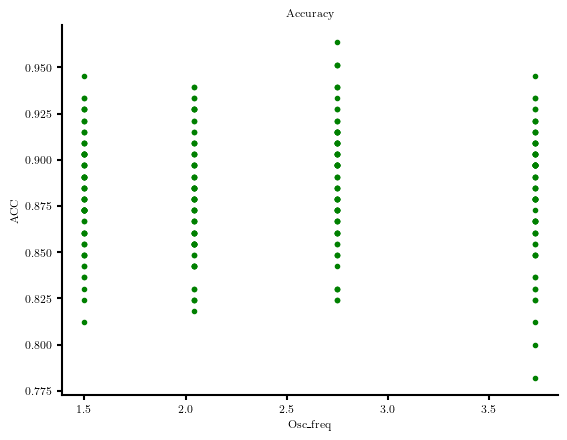

In [5]:
# Plot accuracies of all trained models over Freq

acc_threshold = 0.70
acc_indices = []
for i in range(len(data_list)):
    if data_list[i]["or_acc"]>acc_threshold:
        plt.scatter(data_list[i]["loss_f"], data_list[i]["or_acc"], color = 'green')
        acc_indices.append(i)
    else:
        plt.scatter(data_list[i]["loss_f"], data_list[i]["or_acc"], color = 'red')

plt.xlabel("Osc_freq")
plt.ylabel("ACC")
plt.title("Accuracy");

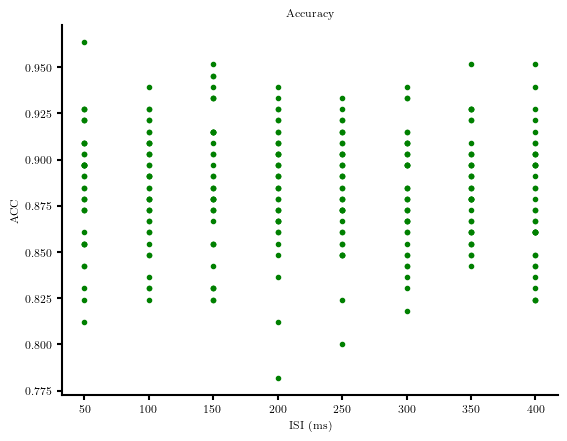

In [6]:
# Plot accuracies of all trained models over ISI

for i in range(len(data_list)):
    if data_list[i]["or_acc"]>acc_threshold:
        plt.scatter(data_list[i]["ISI"]*10, data_list[i]["or_acc"], color = 'green')
    else:
        plt.scatter(data_list[i]["ISI"]*10, data_list[i]["or_acc"], color = 'red')

plt.xlabel("ISI (ms)")
plt.ylabel("ACC")
plt.title("Accuracy");

Text(0, 0.5, 'Osc_amp')

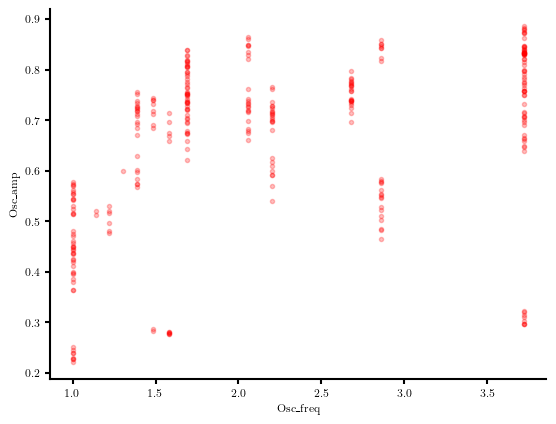

In [7]:
# Plot oscillation frequency versus amplitude

fr_l = summary_settings["freqs_l"]
plt_indices = []
for i in acc_indices:
    osc_freq = fr_l[np.argmax(np.mean(data_list[i]["post_spectrum"],axis=1))]
    osc_amp = np.max(np.mean(data_list[i]["post_spectrum"],axis=1))
    plt.scatter(osc_freq,osc_amp, color = 'red', alpha = 0.25)
plt.xlabel("Osc_freq")
plt.ylabel("Osc_amp")


Text(0, 0.5, 'vex_fr')

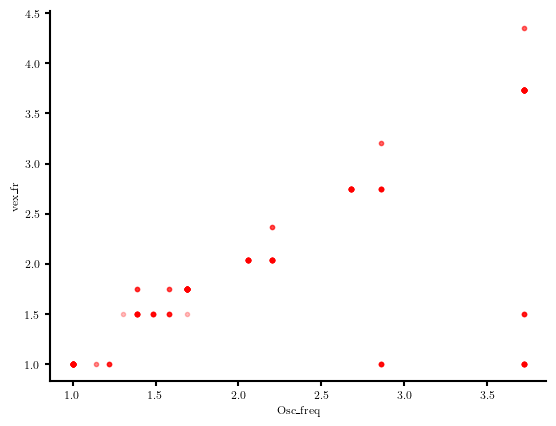

In [8]:
# Plot oscillation frequency versus vex fr

fr_l = summary_settings["freqs_l"]
plt_indices = []
for i in acc_indices:
    osc_freq = fr_l[np.argmax(np.mean(data_list[i]["post_spectrum"],axis=1))]
    vex_fr = data_list[i]["vex_f"]

    plt.scatter(osc_freq,vex_fr, color = 'red', alpha = 0.25)
plt.xlabel("Osc_freq")
plt.ylabel("vex_fr")


In [9]:
eps=10e-7
vexs=np.array(data_list[i]["vex"][:,np.mean(data_list[i]["vex"],axis=0)>eps])
print(vexs.shape)

(10, 52)


Text(0, 0.5, 'vex')

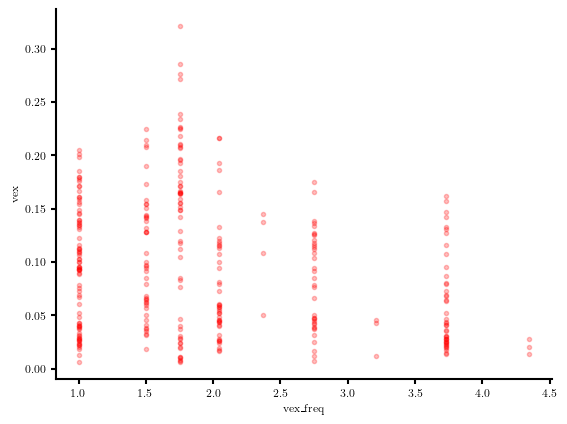

In [10]:
# Plot oscillation frequency versus vex

fr_l = summary_settings["freqs_l"]
plt_indices = []
for i in acc_indices:
    osc_freq= data_list[i]["vex_f"]
    vexs=np.mean(np.max(np.array(data_list[i]["vex"][:,np.mean(data_list[i]["vex"],axis=0)>eps]),axis=0))
    plt.scatter(osc_freq,vexs, color = 'red', alpha = 0.25)
plt.xlabel("vex_freq")
plt.ylabel("vex")


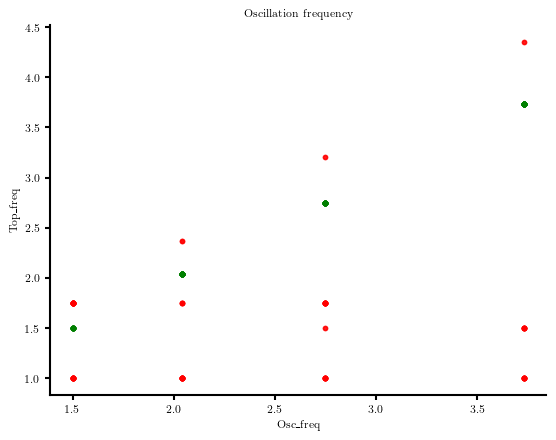

In [11]:
# Plot oscillation frequency for all trained models

fr_l = summary_settings["freqs_l"]
plt_indices = []
for i in acc_indices:
    osc_freq = fr_l[np.argmax(np.mean(data_list[i]["post_spectrum"],axis=1))]
    osc_amp = np.max(np.mean(data_list[i]["post_spectrum"],axis=1))
    osc_freq= data_list[i]["vex_f"]
    if np.isclose(data_list[i]["loss_f"], osc_freq, atol=.2):
        plt.scatter(data_list[i]["loss_f"],osc_freq, color = 'green', alpha = 0.5)
        plt_indices.append(i)

    else:
        plt.scatter(data_list[i]["loss_f"], osc_freq, color = 'red', alpha = 0.5)
plt.xlabel("Osc_freq")
plt.ylabel("Top_freq")
plt.title("Oscillation frequency");


In [12]:
# Plot Kappa per frequency, upper versus lower percentile d'


shcolors = [[0.8,0.8,0.8],[0.7,0.7,0.7],[0.6,0.6,0.6],[0.5,0.5,0.5]]
frs = [1.5, 2.04, 2.75, 3.73]

if calc_vex:
    kappa_all =([np.array(data_list[i]["kappas"][:,np.mean(data_list[i]["vex"],axis=0)!=0]).T for i in plt_indices])
    low_kappa_all = ([np.array(data_list[i]["low_kappas"][:,np.mean(data_list[i]["low_vex"],axis=0)!=0]).T for i in plt_indices])

    shcolors = [[0.8,0.8,0.8],[0.7,0.7,0.7],[0.6,0.6,0.6],[0.5,0.5,0.5]]

    kappas = []
    kappas_se = []
    low_kappas = []
    low_kappas_se = []

    frs = [1.5, 2.04, 2.75, 3.73]
    atol = [0.1,0.1,0.1,0.1]
    for fri, fr in enumerate(frs):
        kappa = [] 
        low_kappa = []
        incl_freq = False
        for i, ni in enumerate(plt_indices):
            if np.isclose(data_list[ni]["loss_f"],fr, atol = atol[fri]):
                incl_freq=True
                kappa.append(kappa_all[i])
                low_kappa.append(low_kappa_all[i])

        if incl_freq:
            print("Including frequency " + str(fr) + " n = " + str(len(kappa)))
            kappas.append(np.mean(np.concatenate(kappa),axis = 0))
            kappas_se.append(np.std([np.mean(kappa[i]) for i in range(len(kappa))])/np.sqrt(len(kappa)))
            low_kappas.append(np.mean(np.concatenate(low_kappa),axis = 0))
            low_kappas_se.append(np.std([np.mean(low_kappa[i]) for i in range(len(low_kappa))])/np.sqrt(len(low_kappa)))





    with mpl.rc_context(fname="matplotlibrc"):

        fig, axs = plt.subplots(1, figsize=(3.2, 2.7))
        fig.tight_layout()
        for i in range(len(kappas)):
            axs.errorbar(
                np.arange(len(summary_settings["freqs"])),
                kappas[i],
                kappas_se[i],
                marker="o",
                color=pltcolors_alt[i],
                zorder=i+5,
                capsize=5,
                elinewidth=2,
                markeredgewidth=2,
                label=str(frs[i])+" Hz",
            )  

            axs.errorbar(
                np.arange(len(summary_settings["freqs"])),
                low_kappas[i],
                low_kappas_se[i],
                marker="o",
                color=shcolors[i],
                zorder=i,
                capsize=5,
                elinewidth=2,
                markeredgewidth=2,
            )

        axs.errorbar(
            np.arange(len(summary_settings["freqs"])),
            low_kappas[i],
            low_kappas_se[i],
            marker="o",
            color=shcolors[i],
            zorder=i,
            capsize=5,
            elinewidth=2,
            markeredgewidth=2,
            label="low 50th",
        )
        axs.set_yticks(np.arange(0, 0.32, 0.05))

        axs.set_xticks(np.arange(len(summary_settings["freqs"]))[::2])
        axs.set_xticklabels(["{:.1f}".format(fr) for fr in summary_settings["freqs"][::2]])
        axs.spines["right"].set_visible(False)
        axs.spines["top"].set_visible(False)
        axs.set_ylabel("Kappa")
        axs.set_xlabel("frequency (Hz)")

        handles, labels = axs.get_legend_handles_labels()
        # remove the errorbars
        handles = [h[0] for h in handles]
        # use them in the legend
        plt.legend(
            handles, labels, numpoints=1, loc="upper right", bbox_to_anchor=(1.4, 1.1)
        )
        plt.savefig("../figures/SummF", facecolor="None", transparent=True)
        plt.savefig("../figures/Kappa_per_F_and_Perc.eps")

In [13]:
# Plot Vex per frequency, upper versus lower percentile d'
if "perm_new" in data_list:
    perms= np.array([[3,1,2],[1,3,2],[3,2,1],[2,3,1],[1,2,3],[2,1,3]])
else:
    perms = np.array([[1,3,2],[1,2,3],[2,1,3],[3,2,1],[3,1,2],[2,3,1]])
perms= np.array([[3,1,2],[1,3,2],[3,2,1],[2,3,1],[1,2,3],[2,1,3]])

if calc_vex:


    vexall =([np.array(data_list[i]["vex"][:,np.mean(data_list[i]["vex"],axis=0)!=0]).T for i in plt_indices])
    shvexall = ([np.array(data_list[i]["shvex"][:,np.mean(data_list[i]["vex"],axis=0)!=0]).T for i in plt_indices])
    low_vexall =([np.array(data_list[i]["low_vex"][:,np.mean(data_list[i]["low_vex"],axis=0)!=0]).T for i in plt_indices])
    low_shvexall = ([np.array(data_list[i]["low_shvex"][:,np.mean(data_list[i]["low_vex"],axis=0)!=0]).T for i in plt_indices])



    shcolors = [[0.8,0.8,0.8],[0.7,0.7,0.7],[0.6,0.6,0.6],[0.5,0.5,0.5]]
    vexs = []
    shvexs = []
    low_vexs = []
    low_shvexs = []
    vexs_se = []
    shvexs_se = []
    low_vexs_se = []
    low_shvexs_se = []

    frs = [1.5, 2.04, 2.75, 3.73]
    atol = [0.2,0.2,0.2,0.2]
    for fri, fr in enumerate(frs):
        vex = [] 
        shvex = []
        low_vex = [] 
        low_shvex = []
        incl_freq = False
        for i, ni in enumerate(plt_indices):
            if np.isclose(data_list[ni]["loss_f"],fr, atol = atol[fri]):
                incl_freq=True
                vex.append(vexall[i])
                shvex.append(shvexall[i])
                low_vex.append(low_vexall[i])
                low_shvex.append(low_shvexall[i])
        if incl_freq:
            print("Including frequency " + str(fr) + " n = " + str(len(vex)))
            vexs.append(np.mean(np.concatenate(vex),axis = 0))
            shvexs.append(np.mean(np.concatenate(shvex),axis = 0))
            vexs_se.append(np.std([np.mean(vex[i]) for i in range(len(shvex))])/np.sqrt(len(vex)))
            shvexs_se.append(np.std([np.mean(shvex[i]) for i in range(len(shvex))])/np.sqrt(len(vex)))

            low_vexs.append(np.mean(np.concatenate(low_vex),axis = 0))
            low_shvexs.append(np.mean(np.concatenate(low_shvex),axis = 0))
            low_vexs_se.append(np.std([np.mean(low_vex[i]) for i in range(len(low_shvex))])/np.sqrt(len(low_vex)))
            low_shvexs_se.append(np.std([np.mean(low_shvex[i]) for i in range(len(low_shvex))])/np.sqrt(len(low_vex)))    




    with mpl.rc_context(fname="matplotlibrc"):

        fig, axs = plt.subplots(1, figsize=(3.2, 2.7))
        fig.tight_layout()
        for i in range(len(kappas)):
            axs.errorbar(
                np.arange(len(summary_settings["freqs"])),
                vexs[i],
                vexs_se[i],
                marker="o",
                color=pltcolors_alt[i],
                zorder=i+5,
                capsize=5,
                elinewidth=2,
                markeredgewidth=2,
                label=str(frs[i])+" Hz",
            )  

            axs.errorbar(
                np.arange(len(summary_settings["freqs"])),
                low_vexs[i],
                low_vexs_se[i],
                marker="o",
                color=shcolors[i],
                zorder=i,
                capsize=5,
                elinewidth=2,
                markeredgewidth=2,
            )
        axs.errorbar(
            np.arange(len(summary_settings["freqs"])),
            low_vexs[i],
            low_vexs_se[i],
            marker="o",
            color=shcolors[i],
            zorder=i,
            capsize=5,
            elinewidth=2,
            markeredgewidth=2,
            label="low 50th",
        )
        axs.set_ylim(-0.02, 0.15)
        axs.set_yticks(np.arange(0, 0.13, 0.05))

        axs.set_xticks(np.arange(len(summary_settings["freqs"]))[::2])
        axs.set_xticklabels(["{:.1f}".format(fr) for fr in summary_settings["freqs"][::2]])
        axs.spines["right"].set_visible(False)
        axs.spines["top"].set_visible(False)
        axs.set_ylabel("variance explained")
        axs.set_xlabel("frequency (Hz)")

        handles, labels = axs.get_legend_handles_labels()
        # remove the errorbars
        handles = [h[0] for h in handles]
        # use them in the legend
        plt.legend(
            handles, labels, numpoints=1, loc="upper right", bbox_to_anchor=(1.4, 1.1)
        )
        plt.savefig("../figures/SummF", facecolor="None", transparent=True)
        plt.savefig("../figures/Vex_per_F_and_Perc.eps")

In [14]:
# Plot Vex per frequency, non-shuffled versus shuffled
if calc_vex:

    with mpl.rc_context(fname="matplotlibrc"):

        fig, axs = plt.subplots(1, figsize=(3.2, 2.7))
        # fig.suptitle("Mean circular variance explained", fontsize = 16)
        fig.tight_layout()
        for i in range(len(kappas)):
            axs.errorbar(
                np.arange(len(summary_settings["freqs"])),
                vexs[i],
                vexs_se[i],
                marker="o",
                color=pltcolors_alt[i],
                zorder=i+5,
                capsize=5,
                elinewidth=2,
                markeredgewidth=2,
                label=str(frs[i])+" Hz",
            )  

            axs.errorbar(
                np.arange(len(summary_settings["freqs"])),
                shvexs[i],#, axis=0),
                shvexs_se[i],
                marker="o",
                color=shcolors[i],
                zorder=i,
                capsize=5,
                elinewidth=2,
                markeredgewidth=2,
            )
        axs.errorbar(
            np.arange(len(summary_settings["freqs"])),
            shvexs[i],#, axis=0),
            shvexs_se[i],
            marker="o",
            color=shcolors[i],
            zorder=i,
            capsize=5,
            elinewidth=2,
            markeredgewidth=2,
            label="shuffled",
        )
        axs.set_ylim(-0.02, 0.14)
        axs.set_yticks(np.arange(0, 0.13, 0.05))

        axs.set_xticks(np.arange(len(summary_settings["freqs"]))[::2])
        axs.set_xticklabels(["{:.1f}".format(fr) for fr in summary_settings["freqs"][::2]])
        axs.spines["right"].set_visible(False)
        axs.spines["top"].set_visible(False)
        axs.set_ylabel("variance explained")
        axs.set_xlabel("frequency (Hz)")

        handles, labels = axs.get_legend_handles_labels()
        # remove the errorbars
        handles = [h[0] for h in handles]
        # use them in the legend
        plt.legend(
            handles, labels, numpoints=1, loc="upper right", bbox_to_anchor=(1.4, 1.1)
        )
        plt.savefig("../figures/SummF", facecolor="None", transparent=True)
        plt.savefig("../figures/VEX_per_F_and_Shuffle.eps")

In [15]:
# Plot proportions of phase orders exploited by models from each training frequency


phase_orders = []
phase_orders_v = []
phase_orders_counts = []
frs = [1.5, 2.04, 2.75, 3.73]

for fr in frs:
    phase_orders_fr = [] 
    phase_orders_fr_counts = [] 

    incl_freq = False
    for i in plt_indices:
        if np.isclose(data_list[i]["loss_f"],fr, atol = 0.2) and np.isclose(data_list[i]["ISI"],20, atol = 0.2):
            incl_freq=True
            phase_orders_fr.append(np.array(data_list[i]["phase_order"])/np.sum(data_list[i]["phase_order"]))
            phase_orders_fr_counts.append(np.array(data_list[i]["phase_order"]))

    if incl_freq:
        print("Including frequency " + str(fr) + " n = " + str(len(phase_orders_fr)))
        phase_orders.append(np.mean(phase_orders_fr, axis = 0))
        phase_orders_counts.append(np.sum(phase_orders_fr_counts, axis = 0))

        phase_orders_v.append(np.std(phase_orders_fr, axis = 0)/np.sqrt(len(phase_orders_fr)))



Including frequency 1.5 n = 4
Including frequency 2.04 n = 5
Including frequency 2.75 n = 5
Including frequency 3.73 n = 5


/opt/homebrew/Caskroom/miniforge/base/envs/PhaseC/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


RuntimeError: latex was not able to process the following string:
b'\\n\\\\begin{figure}\\n  \\\\centering\\\\leavevmode\\n  \\\\psfrag{psmarker0}[bl][bl][1][35.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily [3 1 2]}}\\n\\\\psfrag{psmarker1}[bl][bl][1][35.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily [1 3 2]}}\\n\\\\psfrag{psmarker2}[bl][bl][1][35.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily [3 2 1]}}\\n\\\\psfrag{psmarker3}[bl][bl][1][35.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily [2 3 1]}}\\n\\\\psfrag{psmarker4}[bl][bl][1][35.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily [1 2 3]}}\\n\\\\psfrag{psmarker5}[bl][bl][1][35.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily [2 1 3]}}\\n\\\\psfrag{psmarker6}[bl][bl][1][0.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily Order}}\\n\\\\psfrag{psmarker7}[bl][bl][1][0.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily $\\\\mathdefault{0}$}}\\n\\\\psfrag{psmarker8}[bl][bl][1][0.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily $\\\\mathdefault{10}$}}\\n\\\\psfrag{psmarker9}[bl][bl][1][0.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily $\\\\mathdefault{20}$}}\\n\\\\psfrag{psmarker10}[bl][bl][1][0.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily $\\\\mathdefault{30}$}}\\n\\\\psfrag{psmarker11}[bl][bl][1][90.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily Matching (%)}}\\n\\\\psfrag{psmarker12}[bl][bl][1][0.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily Freq: 1.5}}\\n\\\\psfrag{psmarker13}[bl][bl][1][0.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily Freq: 2.04}}\\n\\\\psfrag{psmarker14}[bl][bl][1][0.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily Freq: 2.75}}\\n\\\\psfrag{psmarker15}[bl][bl][1][0.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily Freq: 3.73}}\\n  \\\\includegraphics*[angle=0]{/private/var/folders/7z/c9g_hq_9025gxx730qgmlh4w0000gn/T/tmpiuktjw9d/tmp.ps}\\n\\\\end{figure}'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.24 (TeX Live 2022) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../81b5184c88de09565687b47b093ea494.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-02-24>
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2022/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/local/texlive/2022/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2022/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2022/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/color.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics-cfg/color.cfg)
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics-def/dvips.def)
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/dvipsnam.def))
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/graphics.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/trig.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics-cfg/graphics.cfg)))
(/usr/local/texlive/2022/texmf-dist/tex/latex/psfrag/psfrag.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 81b5184c88de09565687b47b093ea494.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
)
Runaway argument?
{\fontsize {8.000000}{10.000000}\color [rgb]{0.000,0.000,0.000} {\rmfamily \ETC
.
! File ended while scanning use of \@@@psfrag.
<inserted text> 
                \par 
<*> ../81b5184c88de09565687b47b093ea494.tex
                                           
No pages of output.
Transcript written on 81b5184c88de09565687b47b093ea494.log.




/opt/homebrew/Caskroom/miniforge/base/envs/PhaseC/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


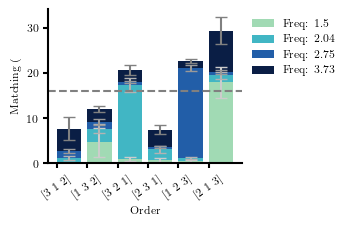

In [16]:

with mpl.rc_context(fname="matplotlibrc"):

    plt.subplots(figsize=(2.5, 2))
    ax1 = plt.subplot(111, facecolor="white")  # , projection='polar')
    
    ax1.bar(np.arange(len(perms)),phase_orders[0]*25, color=pltcolors_alt[0],
            yerr=phase_orders_v[0]*25, 
            align='edge',  ecolor=shcolors[0], capsize=4, label ='Freq: '+ str(frs[0]))
    for i in range(1,len(phase_orders)):
        ax1.bar(np.arange(len(perms)),phase_orders[i]*25, color=pltcolors_alt[i], bottom = np.sum(phase_orders[:i],axis = 0)*25,
            yerr=phase_orders_v[i]*25, 
            align='edge',  ecolor=shcolors[i], capsize=4, label ='Freq: '+ str(frs[i]))
     
    ax1.legend(bbox_to_anchor = (1,1))
    ax1.axhline(16, linestyle="--", color="grey")
    ax1.set_ylim(0)#, 35)
    ax1.set_xticks(np.arange(len(perms)))
    plt.xticks(rotation=35)
    plt.xlabel("Order")

    ax1.set_xticklabels(perms)
    ax1.set_ylabel("Matching (%)")


    plt.savefig("../figures/model_phaseorders.eps")
    

/opt/homebrew/Caskroom/miniforge/base/envs/PhaseC/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


RuntimeError: latex was not able to process the following string:
b'\\n\\\\begin{figure}\\n  \\\\centering\\\\leavevmode\\n  \\\\psfrag{psmarker0}[bl][bl][1][35.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily [3 1 2]}}\\n\\\\psfrag{psmarker1}[bl][bl][1][35.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily [1 3 2]}}\\n\\\\psfrag{psmarker2}[bl][bl][1][35.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily [3 2 1]}}\\n\\\\psfrag{psmarker3}[bl][bl][1][35.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily [2 3 1]}}\\n\\\\psfrag{psmarker4}[bl][bl][1][35.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily [1 2 3]}}\\n\\\\psfrag{psmarker5}[bl][bl][1][35.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily [2 1 3]}}\\n\\\\psfrag{psmarker6}[bl][bl][1][0.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily Order}}\\n\\\\psfrag{psmarker7}[bl][bl][1][0.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily $\\\\mathdefault{0}$}}\\n\\\\psfrag{psmarker8}[bl][bl][1][0.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily $\\\\mathdefault{100}$}}\\n\\\\psfrag{psmarker9}[bl][bl][1][0.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily $\\\\mathdefault{200}$}}\\n\\\\psfrag{psmarker10}[bl][bl][1][0.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily $\\\\mathdefault{300}$}}\\n\\\\psfrag{psmarker11}[bl][bl][1][0.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily $\\\\mathdefault{400}$}}\\n\\\\psfrag{psmarker12}[bl][bl][1][90.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily Matching (%)}}\\n\\\\psfrag{psmarker13}[bl][bl][1][0.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily Freq: 1.5}}\\n\\\\psfrag{psmarker14}[bl][bl][1][0.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily Freq: 2.04}}\\n\\\\psfrag{psmarker15}[bl][bl][1][0.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily Freq: 2.75}}\\n\\\\psfrag{psmarker16}[bl][bl][1][0.000000]{\\\\fontsize{8.000000}{10.000000}\\\\color[rgb]{0.000,0.000,0.000} {\\\\rmfamily Freq: 3.73}}\\n  \\\\includegraphics*[angle=0]{/private/var/folders/7z/c9g_hq_9025gxx730qgmlh4w0000gn/T/tmp2buu8bgn/tmp.ps}\\n\\\\end{figure}'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.24 (TeX Live 2022) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../88bc1e96dc289dbe0f181a27866dbcb3.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-02-24>
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2022/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/local/texlive/2022/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2022/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2022/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/color.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics-cfg/color.cfg)
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics-def/dvips.def)
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/dvipsnam.def))
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/graphics.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/trig.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics-cfg/graphics.cfg)))
(/usr/local/texlive/2022/texmf-dist/tex/latex/psfrag/psfrag.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 88bc1e96dc289dbe0f181a27866dbcb3.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
)
Runaway argument?
{\fontsize {8.000000}{10.000000}\color [rgb]{0.000,0.000,0.000} {\rmfamily \ETC
.
! File ended while scanning use of \@@@psfrag.
<inserted text> 
                \par 
<*> ../88bc1e96dc289dbe0f181a27866dbcb3.tex
                                           
No pages of output.
Transcript written on 88bc1e96dc289dbe0f181a27866dbcb3.log.




/opt/homebrew/Caskroom/miniforge/base/envs/PhaseC/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


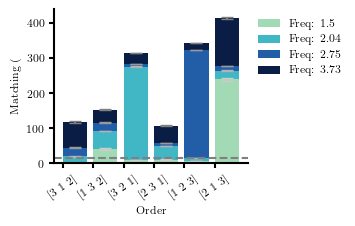

In [ ]:

with mpl.rc_context(fname="matplotlibrc"):

    plt.subplots(figsize=(2.5, 2))
    ax1 = plt.subplot(111, facecolor="white")  # , projection='polar')
    
    ax1.bar(np.arange(len(perms)),phase_orders_counts[0], color=pltcolors_alt[0],
            yerr=phase_orders_v[0]*25, 
            align='edge',  ecolor=shcolors[0], capsize=4, label ='Freq: '+ str(frs[0]))
    for i in range(1,len(phase_orders_counts)):
        ax1.bar(np.arange(len(perms)),phase_orders_counts[i], color=pltcolors_alt[i], bottom = np.sum(phase_orders_counts[:i],axis = 0),
            yerr=phase_orders_v[i]*25, 
            align='edge',  ecolor=shcolors[i], capsize=4, label ='Freq: '+ str(frs[i]))
     
    ax1.legend(bbox_to_anchor = (1,1))
    ax1.axhline(16, linestyle="--", color="grey")
    ax1.set_ylim(0)#, 35)
    ax1.set_xticks(np.arange(len(perms)))
    plt.xticks(rotation=35)
    plt.xlabel("Order")

    ax1.set_xticklabels(perms)
    ax1.set_ylabel("Matching (%)")


    plt.savefig("../figures/model_phaseorders.eps")

In [17]:
for i in range(len(phase_orders)):
    print(scipy.stats.chisquare(phase_orders_counts[i])[1])

3.4882777762844163e-178
1.9766200002165554e-150
3.7613725021469814e-237
2.227713404340834e-32


In [18]:
# Plot proportions of phase orders exploited by models from each training frequency and ISI, in seperate plots

phase_orders = []
phase_orders_v = []
phase_orders_counts = []
freq_ISI = []
freqInds=[]
ISIInds=[]
phase_order_list = []

ISIs=summary_settings["ISIs"]
#frs = summary_settings["freqs"]
frs = [1.5, 2.04, 2.75, 3.73]
result =np.zeros((len(ISIs),len(frs)))
prediction =np.zeros((len(ISIs),len(frs)))
sign_and_corr = np.zeros((len(ISIs),len(frs)))
RNN_order = np.zeros((len(ISIs),len(frs)))
for i_fr,fr in enumerate(frs):
    for i_ISI, ISI in enumerate(ISIs):
        phase_orders_fr = [] 
        phase_orders_fr_counts = []
        incl_freq_ISI = False
        
        #loop through all models
        for i in plt_indices:
            #osc_freq = data_list[i]["vex_f"] 
            osc_freq = data_list[i]["loss_f"]
            #osc_freq = fr_l[np.argmax(np.mean(data_list[i]["post_spectrum"],axis=1))]

            if np.isclose(osc_freq,fr, atol = 0.2):
                if np.isclose(data_list[i]["ISI"],ISI, atol = .1):
                    incl_freq_ISI=True
                    phase_orders_fr.append(np.array(data_list[i]["phase_order"])/np.sum(data_list[i]["phase_order"]))
                    phase_orders_fr_counts.append(np.array(data_list[i]["phase_order"]))
                    for order_ind in range(6):
                        phase_order_list.extend([[order_ind,fr,ISI*10+200]]*int(data_list[i]["phase_order"][order_ind]))
   
        
        # Summary of particular models with freq and ISI
        if incl_freq_ISI:
            print("Including frequency " + str(fr) + ", \n ISI " + str(ISI) +  ", n = " + str(len(phase_orders_fr)))
            phase_orders.append(np.mean(phase_orders_fr, axis = 0))
            phase_orders_v.append(np.std(phase_orders_fr, axis = 0)/np.sqrt(len(phase_orders_fr)))
            phase_orders_counts.append(np.sum(phase_orders_fr_counts, axis = 0))
            freq_ISI.append("F: " +str(fr) + ", ISI: "+str(ISI*10+200))
            freqInds.append(i_fr)
            ISIInds.append(i_ISI)

            
#fig=plt.figure(figsize=(12, 6))


colors = [pltcolors_alt[1],'lightblue',pltcolors_alt[3],'lightblue',pltcolors_alt[0],pltcolors_alt[2],]

def plt_ind(i):
    return ((i*4+1)%12)+i//3

with mpl.rc_context(fname="matplotlibrc"):
    for i in range(len(phase_orders)):
        pred_i, pred = get_phase_order(frs[freqInds[i]],ISIs[ISIInds[i]]*10+200)
        #if "perm_new" not in data_list:
        #    pred_i=new_to_old_perm_inds(pred_i)
        print("PREDICTION")
        print(pred_i,pred,frs[freqInds[i]],ISIs[ISIInds[i]]*10+200)
        print("STATS")
        print(phase_orders_counts[i],scipy.stats.chisquare(phase_orders_counts[i])[1])
        result[ISIInds[i],freqInds[i]]=phase_orders[i][pred_i]*100
        prediction[ISIInds[i],freqInds[i]]=pred_i
        RNN_order[ISIInds[i],freqInds[i]]=np.argmax(phase_orders[i])
        if np.argmax(phase_orders[i])==pred_i and scipy.stats.chisquare(phase_orders_counts[i])[1]<1e-5:
            sign_and_corr[ISIInds[i],freqInds[i]]=1
        """
        print((i+1)*100+11+i)
        #ax1 = plt.subplot(101+len(phase_orders)*10+i, facecolor="white")  
        1,5,9,2,6,10,3,7,11,4,8,12
        ax1 = fig.add_subplot(3, 4,plt_ind(i))
        ax1.bar(np.arange(len(perms)),phase_orders[i]*100, color=colors,
                yerr=phase_orders_v[i]*100, 
                align='edge',  ecolor=shcolors[-1], capsize=4)#, label ='Freq: '+ str(frs[i]))
        #ax1.set_title(freq_ISI[i])
        ax1.axhline(16, linestyle="--", color="grey")
        ax1.axhline(99,pred_i/6+0.04,(pred_i+1)/6-0.04, linestyle="-", color=pltcolors[-1])

    
        ax1.set_ylim(0,100)
        ax1.set_xticks(np.arange(len(perms)))
        plt.xticks(rotation=35)
        if plt_ind(i)>8:
            ax1.set_xticklabels(perms)
            ax1.set_xlabel("Order")

        else:
            ax1.set_xticklabels([])
        if not i//3==0:
            ax1.set_yticklabels([])
        else:
            ax1.set_ylabel("Matching (%)")
        """

    plt.rcParams["pdf.use14corefonts"] = True


    plt.savefig("../figures/model_phaseorders_sem.pdf", facecolor='white')

Including frequency 1.5, 
 ISI 5, n = 3
Including frequency 1.5, 
 ISI 10, n = 3
Including frequency 1.5, 
 ISI 15, n = 3
Including frequency 1.5, 
 ISI 20, n = 4
Including frequency 1.5, 
 ISI 25, n = 3
Including frequency 1.5, 
 ISI 30, n = 4
Including frequency 1.5, 
 ISI 35, n = 3
Including frequency 1.5, 
 ISI 40, n = 3
Including frequency 2.04, 
 ISI 5, n = 6
Including frequency 2.04, 
 ISI 10, n = 6
Including frequency 2.04, 
 ISI 15, n = 5
Including frequency 2.04, 
 ISI 20, n = 5
Including frequency 2.04, 
 ISI 25, n = 5
Including frequency 2.04, 
 ISI 30, n = 6
Including frequency 2.04, 
 ISI 35, n = 6
Including frequency 2.04, 
 ISI 40, n = 5
Including frequency 2.75, 
 ISI 5, n = 5
Including frequency 2.75, 
 ISI 10, n = 5
Including frequency 2.75, 
 ISI 15, n = 3
Including frequency 2.75, 
 ISI 20, n = 5
Including frequency 2.75, 
 ISI 25, n = 4
Including frequency 2.75, 
 ISI 30, n = 5
Including frequency 2.75, 
 ISI 35, n = 4
Including frequency 2.75, 
 ISI 40, n = 5
Inc

<Figure size 640x480 with 0 Axes>

In [19]:
def add_numbers(ax, grid, fontsize,float_labels=False,color='black'):
    """add numbers to covariance matrix plots"""
    for (j, i), label in np.ndenumerate(grid):
        if float_labels:
            ax.text(i, j, "{:.2f}".format(label), ha="center", va="center", fontsize=fontsize, color=color)
        else:
            ax.text(i, j, int(label), ha="center", va="center", fontsize=fontsize, color=color)


(-200.0, 200.0)


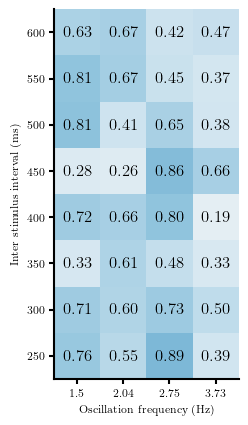

In [20]:
plt.imshow(result,origin='lower',cmap='RdBu',vmin=-200,vmax=200)
plt.xticks(np.arange(len(frs)),frs)
plt.yticks(np.arange(len(ISIs)),[ISI*10+200 for ISI in ISIs])
plt.ylabel("Inter stimulus interval (ms)")
plt.xlabel("Oscillation frequency (Hz)")
add_numbers(plt.gca(),result/100,12,float_labels=True)
print(plt.gci().get_clim())

In [21]:
np.mean(result[result>0])

56.434427837243284

In [22]:
def add_numbers_cont(ax, grid, fontsize,color_cont):
    """add numbers to covariance matrix plots"""
    for (j, i), label in np.ndenumerate(grid):
        if color_cont[j,i]==0:
            color='black'
        elif color_cont[j,i]==4:
            color='black'
        else:
            color='lightgrey'
        ax.text(i, j, "{:.2f}".format(label), ha="center", va="center", fontsize=fontsize, color=color)

def add_strings(ax, grid, fontsize,color='black'):
    """add numbers to covariance matrix plots"""
    for (j, i), label in np.ndenumerate(grid):
        ax.text(i, j, label.decode(), ha="center", va="center", fontsize=fontsize, color=color)
       

In [23]:
print(sign_and_corr[0,0].decode()[0])

AttributeError: 'numpy.float64' object has no attribute 'decode'

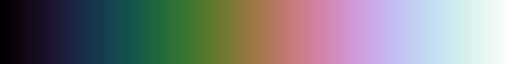

In [24]:
mpl.colormaps['cubehelix']

In [25]:
RNN_order

array([[0., 5., 2., 2.],
       [0., 5., 2., 4.],
       [5., 2., 2., 0.],
       [5., 2., 4., 5.],
       [5., 2., 4., 2.],
       [2., 4., 0., 2.],
       [2., 4., 5., 4.],
       [2., 4., 2., 4.]])

[-0.5  0.5  1.5  2.5  3.5  4.5  5.5]


/opt/homebrew/Caskroom/miniforge/base/envs/PhaseC/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


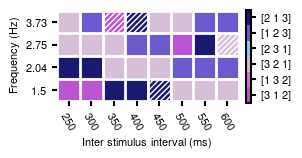

In [28]:
orders = np.array([[3,1,2],[1,3,2],[3,2,1],[2,3,1],[1,2,3],[2,1,3]])

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "Helvetica"
mpl.rcParams['font.size'] = 8
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams.update({
    'font.family': 'Helvetica'
})
with mpl.rc_context(fname="matplotlibrc"):

    fig=plt.figure(figsize=(2.5,1.3))
    #col_dict={0:pltcolors_alt[1],
    #          2:pltcolors_alt[3],
    #          4:pltcolors_alt[0],
    #          5:pltcolors_alt[2]}
    # create a colormap
    i=int(255/5)
    b=0
    map = mpl.colormaps['rainbow']
    colors = map(np.arange(0,map.N)) 
    col_dict={0:colors[i*0+b],
            1:colors[i*1+b],
            2:colors[i*2+b],
            3:colors[i*3+b],
            4:colors[i*4+b],
            5:colors[i*5+b]}

    #["#ea5545", "#f46a9b", "#ef9b20", "#edbf33", "#ede15b", "#bdcf32", "#87bc45", "#27aeef", "#b33dc6"]

    col_dict={0:'#ea5545',
            1:'#ef9b20',
            2:'#ede15b',
            3:'#bdcf32',
            4:'#27aeef',
            5:'#b33dc6'}
    col_dict={0:'mediumorchid',
            1:'orchid',
            2:'thistle',
            3:'lightskyblue',
            4:'slateblue',
            5:'midnightblue'}
    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

    #  description of each category
    labels = np.array([orders[0],orders[1],orders[2],orders[3],orders[4],orders[5]])
    len_lab = len(labels)


    norm_bins = np.sort([*col_dict.keys()]) + 0.5
    norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
    print(norm_bins)

    norm = mpl.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
    fmt = mpl.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])


    # Plot our figure
    im = plt.imshow(RNN_order.T, origin='lower',cmap=cm, norm=norm,alpha=1)#,aspect='auto')

    plt.yticks(np.arange(len(frs)),frs)
    plt.xticks(np.arange(len(ISIs)),[ISI*10+200 for ISI in ISIs],rotation=-60)
    plt.xlabel("Inter stimulus interval (ms)")
    plt.ylabel("Frequency (Hz)")
    #add_strings(plt.gca(),sign_and_corr.T,12)#color_cont=prediction.T)
    #print(plt.gci().get_clim())
    plt.gca().set_yticks(np.arange(-.5, len(frs), 1), minor=True)
    plt.gca().set_xticks(np.arange(-.5, len(ISIs), 1), minor=True)
    plt.gca().tick_params(axis='both', which='minor', labelsize=0, length=0)
    plt.grid(color='white', linestyle='-', linewidth=2,which='minor')

    plt.gca().spines[['bottom','left']].set_visible(False)

    for i in range(len(ISIs)):
        for j in range(len(frs)):
                if sign_and_corr[i,j]<0.5:
                        plt.gca().add_patch(mpl.patches.Rectangle((i-.5,j-.5),1,1,hatch='//////',fill=False,snap=False,color='white'))


    diff = norm_bins[1:] - norm_bins[:-1]
    tickz = norm_bins[:-1] + diff / 2
    cb = plt.colorbar(im, format=fmt, ticks=tickz,fraction=0.024, pad=0.04)
    plt.savefig("/Users/matthijs/Desktop/fig.pdf")
    #plt.rcParams["pdf.use14corefonts"] = True


In [ ]:
np.save('../data/phase_order_model.npy',np.array(phase_order_list))

In [ ]:
mpl.colormaps['tab20b'].colors[0]

(0.2235294117647059, 0.23137254901960785, 0.4745098039215686)